# Credit Card Lead Prediction 💳
This notebook is based on the Analytics Vidhya Hackathon which is used to predict wheather or not user is intent towards buying the credit card using the different features like `Gender`, `Age`, `Region Code`, etc.

**Evaluation Metric: ROC AUC Curve**

## Load the Dataset
In this section, we load the dataset and understand the features and value.

In [2]:
!pip install missingno --quiet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import imblearn

color="orange"

In [2]:
train_ds = pd.read_csv("../data/train.csv")
train_ds.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [3]:
test_ds = pd.read_csv("../data/test.csv")
test_ds.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


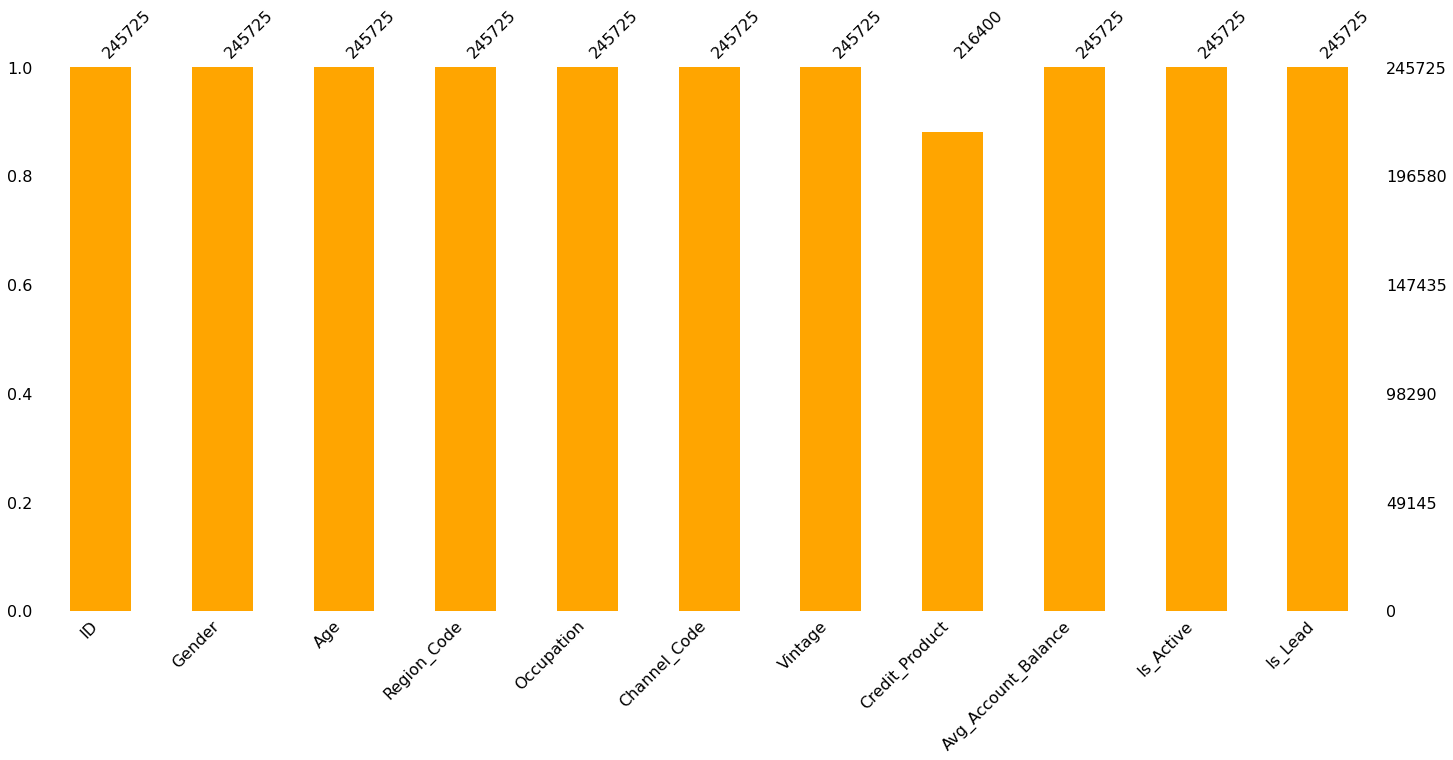

In [4]:
missingno.bar(train_ds, color=color);

From this graph, we can see that `Credict Product` column have a missing value in training dataset.

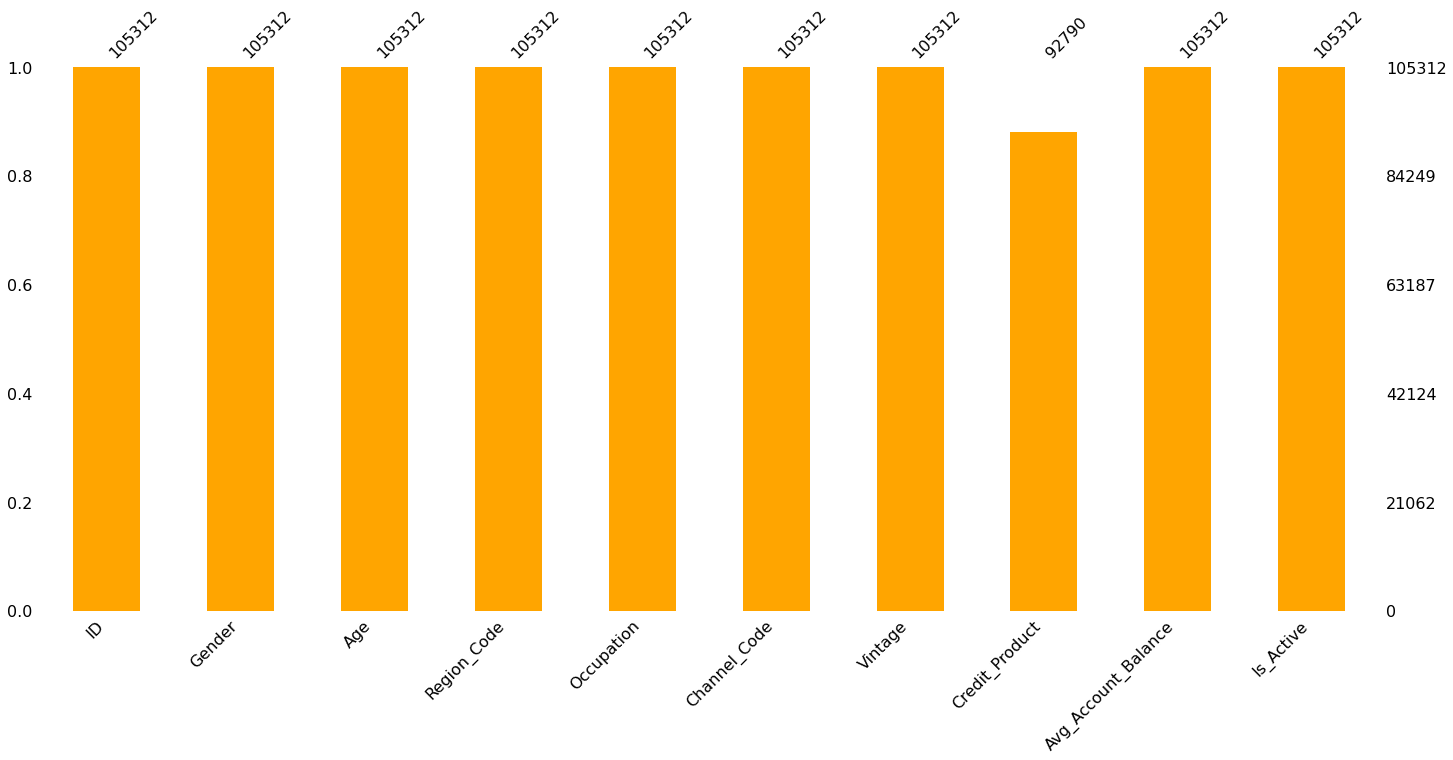

In [5]:
missingno.bar(test_ds, color=color);

In test dataset, we also have a missing value in `Credit Product` column.

## Perform Statistics
In this section, we perform some statistics operation like mean, min, max, skew to understand the dataset more clearly.

In [6]:
train_ds.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


We have quit important information regarding the numerical dataset. This can be helpful when we choose the ml model.

In [7]:
test_ds.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000000,105312.000000,1.053120e+05
mean,43.871002,46.842819,1.134195e+06
std,14.872890,32.273634,8.662430e+05
min,24.000000,7.000000,2.259700e+04
25%,30.000000,20.000000,6.039822e+05
50%,43.000000,32.000000,8.966345e+05
75%,54.000000,73.000000,1.371598e+06
max,85.000000,135.000000,9.908858e+06


**Vintage: It refers to the month or quarter in which account was opened.**

In [8]:
for col in train_ds.columns:
    if pd.api.types.is_numeric_dtype(train_ds[col]):
        print(f"{col} skew: {train_ds[col].skew()}")

Age skew: 0.6189922275209511
Vintage skew: 0.7901885721179357
Avg_Account_Balance skew: 2.968726515557337
Is_Lead skew: 1.2355959031537753


We have a lot of skewness in `Avg Account Balance` column which we need to normalize for making better prediction.

In [9]:
print("Training Dataset...")
print(f"Length of the dataset: {len(train_ds)}")
print(f"Shape of the dataset: {train_ds.shape}")
print(f"Number of missing columns: {(train_ds.isna().sum() != 0).sum()}")
print("\n")
print("Test Dataset...")
print(f"Length of the dataset: {len(test_ds)}")
print(f"Shape of the dataset: {test_ds.shape}")
print(f"Number of missing columns: {(test_ds.isna().sum() != 0).sum()}")

Training Dataset...
Length of the dataset: 245725
Shape of the dataset: (245725, 11)
Number of missing columns: 1


Test Dataset...
Length of the dataset: 105312
Shape of the dataset: (105312, 10)
Number of missing columns: 1


## Exploratory Data Analysis
In this section, we perform the data visualization to understand the relation between the dependent and independent variables.

In [10]:
train_ds.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


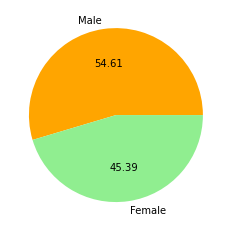

In [11]:
plt.pie(train_ds['Gender'].value_counts(), labels=['Male', 'Female'], autopct="%.2f", colors=['orange', 'lightgreen']);

So, we have more numbers of male who have qualified for getting the credit card.

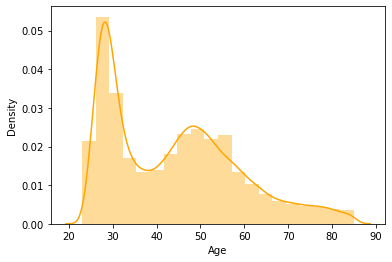

In [12]:
sns.distplot(train_ds['Age'], bins=20, color=color);

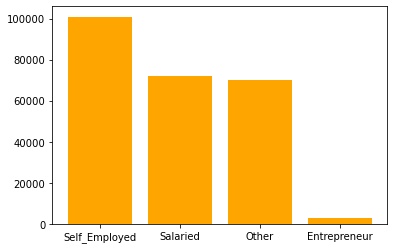

In [13]:
plt.bar(train_ds['Occupation'].value_counts().keys(),
        train_ds['Occupation'].value_counts(), 
        color=color);

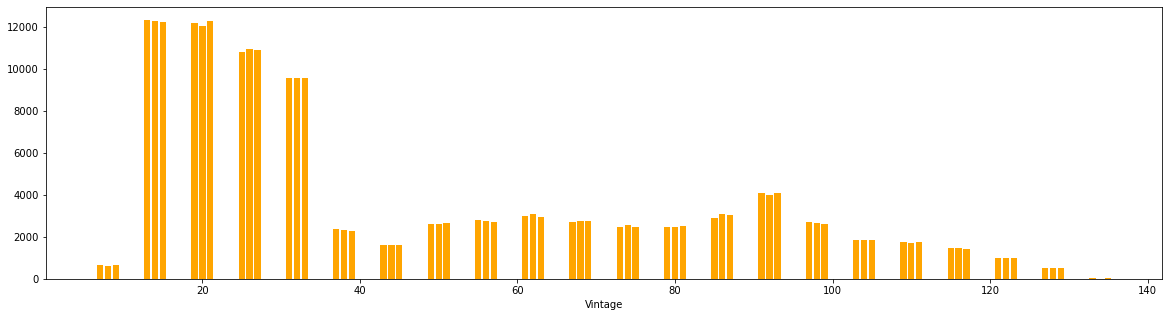

In [14]:
plt.figure(figsize=(20, 5))
plt.bar(train_ds['Vintage'].value_counts().keys(), 
        train_ds['Vintage'].value_counts(), 
        color=color)
plt.xlabel("Vintage");

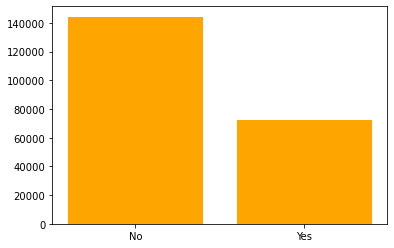

In [15]:
plt.bar(train_ds['Credit_Product'].value_counts().keys(), train_ds['Credit_Product'].value_counts(), color=color);

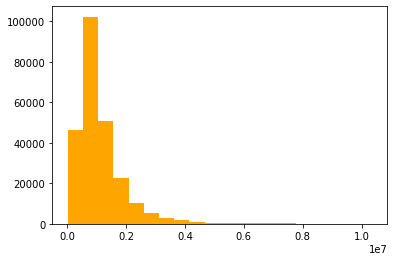

In [16]:
plt.hist(train_ds['Avg_Account_Balance'], bins=20, color=color);

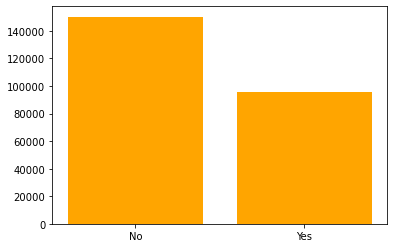

In [17]:
plt.bar(train_ds['Is_Active'].value_counts().keys(), 
        train_ds['Is_Active'].value_counts(), 
        color=color);

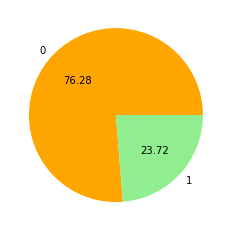

In [18]:
plt.pie(train_ds['Is_Lead'].value_counts(), 
        labels=train_ds['Is_Lead'].value_counts().keys(),
        colors=['orange', 'lightgreen'], autopct="%.2f");

So, we have unbalance dataset. We need to use some algorithms to perform oversampling or undersampling.

In [19]:
numerical_col = ['Age', 'Vintage', 'Avg_Account_Balance']

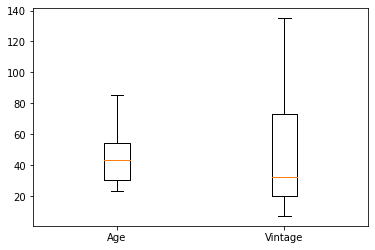

In [20]:
plt.boxplot(train_ds[numerical_col[:-1]], labels=numerical_col[:-1]);

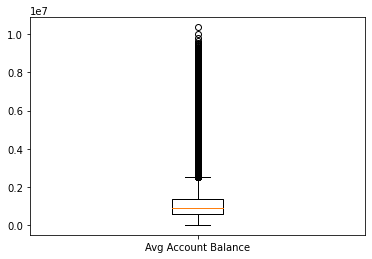

In [21]:
plt.boxplot(train_ds[numerical_col[-1]], labels=["Avg Account Balance"]);

We need to remove this outliers from the `Avg Account Balance` column.

## Feature Engineering
In this section, we resolve all the errorness from the dataset, convert the categorical dataset into numerical dataset and extract the new features from the given one.

So, this section is divided into three sub-section:
- Remove errorness.
- Convert Categorical features to Numerical Features.
- Extract new features.

But before that we need to combine the training and testing dataset.

In [287]:
train_ds['train_test'] = "train"
test_ds['train_test'] = "test"
train_ds_no_target = train_ds.drop('Is_Lead', axis=1)
combine_ds = pd.concat([train_ds_no_target,test_ds])
combine_ds.head()
combine_ds.tail()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test
105307,DBENJOYI,Male,52,RG268,Salaried,X2,86,Yes,4242558,Yes,test
105308,CWQ72DWS,Male,55,RG277,Other,X2,86,Yes,1159153,No,test
105309,HDESC8GU,Male,35,RG254,Salaried,X4,15,No,1703727,No,test
105310,2PW4SFCA,Male,53,RG254,Other,X3,93,No,737178,Yes,test
105311,F2NOYPPZ,Male,27,RG256,Salaried,X1,21,No,591565,No,test


### Remove Errorness

In [288]:
q1 = combine_ds['Avg_Account_Balance'].quantile(0.25)
q3 = combine_ds['Avg_Account_Balance'].quantile(0.75)
IQR = q3 - q1
combine_ds['Avg_Account_Balance'] = np.where(combine_ds['Avg_Account_Balance'] < q1, 
                                           (q1 - (IQR*1.5)), 
                                            combine_ds['Avg_Account_Balance'])
combine_ds['Avg_Account_Balance'] = np.where(combine_ds['Avg_Account_Balance'] > q3, 
                                           (q3 + (IQR*1.5)), 
                                            combine_ds['Avg_Account_Balance'])

In [289]:
combine_ds.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696.0,No,train
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,-541765.5,No,train
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,2514102.5,Yes,train
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,-541765.5,No,train
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787.0,No,train


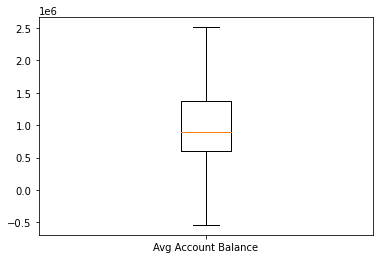

In [290]:
plt.boxplot(combine_ds['Avg_Account_Balance'], labels=['Avg Account Balance']);

### Convert Categorical to Numerical Features

In [291]:
combine_ds['Credit_Product'].fillna("missing", inplace=True)

In [292]:
encoder = LabelEncoder()
combine_ds['Gender'] = encoder.fit_transform(combine_ds['Gender'])
combine_ds['Occupation'] = encoder.fit_transform(combine_ds['Occupation'])
combine_ds['Credit_Product'] = encoder.fit_transform(combine_ds['Credit_Product'])
combine_ds['Is_Active'] = encoder.fit_transform(combine_ds['Is_Active'])

In [293]:
combine_ds.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test
0,NNVBBKZB,0,73,RG268,1,X3,43,0,1045696.0,0,train
1,IDD62UNG,0,30,RG277,2,X1,32,0,-541765.5,0,train
2,HD3DSEMC,0,56,RG268,3,X3,26,0,2514102.5,1,train
3,BF3NC7KV,1,34,RG270,2,X1,19,0,-541765.5,0,train
4,TEASRWXV,0,30,RG282,2,X1,33,0,886787.0,0,train


We remove the ID column from the dataset as it is unique for every user.

### Extract information from the dataset

In [294]:
combine_ds['Region_Code_Id'] = combine_ds['Region_Code'].apply(lambda x: x[:2])
combine_ds['Region_Code_Number'] = combine_ds['Region_Code'].apply(lambda x: x[2:])
combine_ds.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test,Region_Code_Id,Region_Code_Number
0,NNVBBKZB,0,73,RG268,1,X3,43,0,1045696.0,0,train,RG,268
1,IDD62UNG,0,30,RG277,2,X1,32,0,-541765.5,0,train,RG,277
2,HD3DSEMC,0,56,RG268,3,X3,26,0,2514102.5,1,train,RG,268
3,BF3NC7KV,1,34,RG270,2,X1,19,0,-541765.5,0,train,RG,270
4,TEASRWXV,0,30,RG282,2,X1,33,0,886787.0,0,train,RG,282


In [295]:
combine_ds['Channel_Code_Id'] = combine_ds['Channel_Code'].apply(lambda x: x[:1])
combine_ds['Channel_Code_Number'] = combine_ds['Channel_Code'].apply(lambda x: x[1:])
combine_ds.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test,Region_Code_Id,Region_Code_Number,Channel_Code_Id,Channel_Code_Number
0,NNVBBKZB,0,73,RG268,1,X3,43,0,1045696.0,0,train,RG,268,X,3
1,IDD62UNG,0,30,RG277,2,X1,32,0,-541765.5,0,train,RG,277,X,1
2,HD3DSEMC,0,56,RG268,3,X3,26,0,2514102.5,1,train,RG,268,X,3
3,BF3NC7KV,1,34,RG270,2,X1,19,0,-541765.5,0,train,RG,270,X,1
4,TEASRWXV,0,30,RG282,2,X1,33,0,886787.0,0,train,RG,282,X,1


In [296]:
combine_ds['Region_Code_Id'] = encoder.fit_transform(combine_ds['Region_Code_Id'])
combine_ds['Channel_Code_Id'] = encoder.fit_transform(combine_ds['Channel_Code_Id'])
combine_ds.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test,Region_Code_Id,Region_Code_Number,Channel_Code_Id,Channel_Code_Number
0,NNVBBKZB,0,73,RG268,1,X3,43,0,1045696.0,0,train,0,268,0,3
1,IDD62UNG,0,30,RG277,2,X1,32,0,-541765.5,0,train,0,277,0,1
2,HD3DSEMC,0,56,RG268,3,X3,26,0,2514102.5,1,train,0,268,0,3
3,BF3NC7KV,1,34,RG270,2,X1,19,0,-541765.5,0,train,0,270,0,1
4,TEASRWXV,0,30,RG282,2,X1,33,0,886787.0,0,train,0,282,0,1


In [297]:
combine_ds['Region_Code_Number'] = combine_ds['Region_Code_Number'].astype('int8')
combine_ds['Channel_Code_Number'] = combine_ds['Channel_Code_Number'].astype('int8')

In [298]:
combine_ds.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test,Region_Code_Id,Region_Code_Number,Channel_Code_Id,Channel_Code_Number
0,NNVBBKZB,0,73,RG268,1,X3,43,0,1045696.0,0,train,0,12,0,3
1,IDD62UNG,0,30,RG277,2,X1,32,0,-541765.5,0,train,0,21,0,1
2,HD3DSEMC,0,56,RG268,3,X3,26,0,2514102.5,1,train,0,12,0,3
3,BF3NC7KV,1,34,RG270,2,X1,19,0,-541765.5,0,train,0,14,0,1
4,TEASRWXV,0,30,RG282,2,X1,33,0,886787.0,0,train,0,26,0,1


In [299]:
combine_ds.drop(['ID', 'Channel_Code', 'Region_Code'], axis=1, inplace=True)

In [300]:
# combine_ds['Vintage'] = np.log(combine_ds['Vintage'])

In [301]:
# combine_ds['Avg_Account_Balance'] = np.log(combine_ds['Avg_Account_Balance'])

In [302]:
# combine_ds['Age'] = np.log(combine_ds['Age'])

In [303]:
combine_ds.tail()

,Gender,Age,Occupation,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test,Region_Code_Id,Region_Code_Number,Channel_Code_Id,Channel_Code_Number
105307,1,52,2,86,1,2514102.5,1,test,0,12,0,2
105308,1,55,1,86,1,1159153.0,0,test,0,21,0,2
105309,1,35,2,15,0,2514102.5,0,test,0,-2,0,4
105310,1,53,1,93,0,737178.0,1,test,0,-2,0,3
105311,1,27,2,21,0,-541765.5,0,test,0,0,0,1


In [304]:
for col in combine_ds.columns:
    if pd.api.types.is_numeric_dtype(combine_ds[col]):
        print(f"{col} skew: {combine_ds[col].skew()}")

Gender skew: -0.18750632939361359
Age skew: 0.6218635065299406
Occupation skew: -0.30180388259171453
Vintage skew: 0.7905119345487269
Credit_Product skew: 0.9353238650274428
Avg_Account_Balance skew: 0.08458308022430394
Is_Active skew: 0.4504934009489778
Region_Code_Id skew: 0
Region_Code_Number skew: -0.26436152001669294
Channel_Code_Id skew: 0
Channel_Code_Number skew: 0.3880637385268776


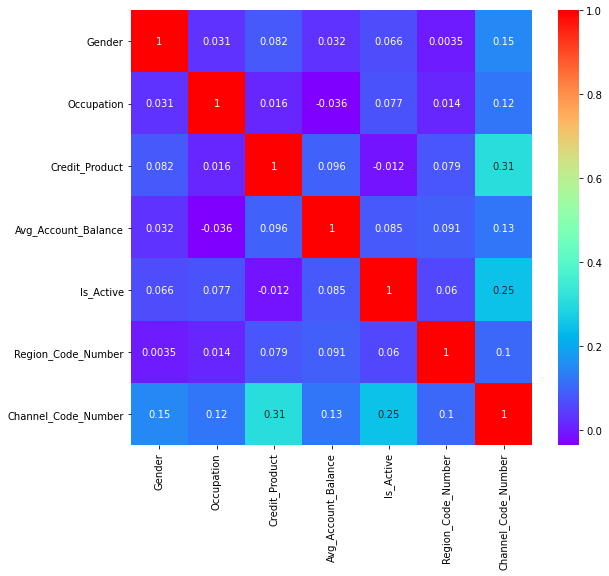

In [305]:
plt.figure(figsize=(9,8))
sns.heatmap(combine_ds.drop(['Channel_Code_Id', 'Region_Code_Id', 'Age', 'Vintage'], axis=1).corr(), annot=True, cmap='rainbow');

In [351]:
def min_max(ds, column = None):
    if column == None:
        column = ['Age', 'Vintage', 'Avg_Account_Balance', 'Region_Code_Number', 
                  'Channel_Code_Number', 'Occupation']
    for col in column:
        min_n = ds[col].min()
        max_n = ds[col].max()
        ds[col] = (ds[col] - min_n)/(max_n - min_n)
    return ds

In [352]:
combine_ds = min_max(combine_ds)
combine_ds.head()

,Gender,Age,Occupation,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test,Region_Code_Id,Region_Code_Number,Channel_Code_Id,Channel_Code_Number,Account_Occupation,Credit_Active
0,0,0.806452,0.333333,0.281250,0,0.519480,0,train,0,0.529412,0,0.666667,1.068550e+06,85444
1,0,0.112903,0.666667,0.195312,0,0.000000,0,train,0,0.794118,0,0.000000,7.982050e+05,85444
2,0,0.532258,1.000000,0.148438,0,1.000000,1,train,0,0.529412,0,0.666667,9.753692e+05,85444
3,1,0.177419,0.666667,0.093750,0,0.000000,0,train,0,0.588235,0,0.000000,7.982050e+05,85444
4,0,0.112903,0.666667,0.203125,0,0.467478,0,train,0,0.941176,0,0.000000,7.982050e+05,85444


In [353]:
value = combine_ds.groupby('Occupation')['Avg_Account_Balance'].mean().to_dict()
combine_ds['Account_Occupation'] = combine_ds['Occupation'].map(value)
combine_ds.head()

,Gender,Age,Occupation,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test,Region_Code_Id,Region_Code_Number,Channel_Code_Id,Channel_Code_Number,Account_Occupation,Credit_Active
0,0,0.806452,0.333333,0.281250,0,0.519480,0,train,0,0.529412,0,0.666667,0.526958,85444
1,0,0.112903,0.666667,0.195312,0,0.000000,0,train,0,0.794118,0,0.000000,0.438491,85444
2,0,0.532258,1.000000,0.148438,0,1.000000,1,train,0,0.529412,0,0.666667,0.496466,85444
3,1,0.177419,0.666667,0.093750,0,0.000000,0,train,0,0.588235,0,0.000000,0.438491,85444
4,0,0.112903,0.666667,0.203125,0,0.467478,0,train,0,0.941176,0,0.000000,0.438491,85444


In [309]:
value = combine_ds.groupby('Credit_Product')['Is_Active'].sum()
combine_ds['Credit_Active'] = combine_ds['Credit_Product'].map(value)
combine_ds.head()

,Gender,Age,Occupation,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test,Region_Code_Id,Region_Code_Number,Channel_Code_Id,Channel_Code_Number,Account_Occupation,Credit_Active
0,0,73,1,43,0,1045696.0,0,train,0,12,0,3,1.068550e+06,85444
1,0,30,2,32,0,-541765.5,0,train,0,21,0,1,7.982050e+05,85444
2,0,56,3,26,0,2514102.5,1,train,0,12,0,3,9.753692e+05,85444
3,1,34,2,19,0,-541765.5,0,train,0,14,0,1,7.982050e+05,85444
4,0,30,2,33,0,886787.0,0,train,0,26,0,1,7.982050e+05,85444


In [354]:
combine_ds = min_max(combine_ds, column=['Account_Occupation', 'Credit_Active'])
combine_ds.head()

,Gender,Age,Occupation,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test,Region_Code_Id,Region_Code_Number,Channel_Code_Id,Channel_Code_Number,Account_Occupation,Credit_Active
0,0,0.806452,0.333333,0.281250,0,0.519480,0,train,0,0.529412,0,0.666667,0.444642,1.0
1,0,0.112903,0.666667,0.195312,0,0.000000,0,train,0,0.794118,0,0.000000,0.000000,1.0
2,0,0.532258,1.000000,0.148438,0,1.000000,1,train,0,0.529412,0,0.666667,0.291386,1.0
3,1,0.177419,0.666667,0.093750,0,0.000000,0,train,0,0.588235,0,0.000000,0.000000,1.0
4,0,0.112903,0.666667,0.203125,0,0.467478,0,train,0,0.941176,0,0.000000,0.000000,1.0


In [312]:
# combine_ds = min_max(combine_ds, column=['Region_Code_Id_Count', 'Channel_Code_Count', 'Gender_Count', 'Is_Active_Count'])

In [355]:
combine_ds.head()

,Gender,Age,Occupation,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,train_test,Region_Code_Id,Region_Code_Number,Channel_Code_Id,Channel_Code_Number,Account_Occupation,Credit_Active
0,0,0.806452,0.333333,0.281250,0,0.519480,0,train,0,0.529412,0,0.666667,0.444642,1.0
1,0,0.112903,0.666667,0.195312,0,0.000000,0,train,0,0.794118,0,0.000000,0.000000,1.0
2,0,0.532258,1.000000,0.148438,0,1.000000,1,train,0,0.529412,0,0.666667,0.291386,1.0
3,1,0.177419,0.666667,0.093750,0,0.000000,0,train,0,0.588235,0,0.000000,0.000000,1.0
4,0,0.112903,0.666667,0.203125,0,0.467478,0,train,0,0.941176,0,0.000000,0.000000,1.0


## Modeling and Experimentation
In this section, we train the different classification ml model and evaluate it using the above mention metric i.e. ROC AUC Curve.

In [356]:
train = combine_ds[combine_ds['train_test'] == "train"]
test = combine_ds[combine_ds['train_test'] == "test"]

In [357]:
train.drop('train_test', axis=1, inplace=True)
train.shape

(245725, 13)

In [358]:
test.drop('train_test', axis=1, inplace=True)
test.shape

(105312, 13)

In [359]:
smote = imblearn.over_sampling.SMOTE()
X, y = smote.fit_resample(train, train_ds.Is_Lead)

In [360]:
len(X), len(y)

(374874, 374874)

In [361]:
X.drop(['Region_Code_Id', 'Channel_Code_Id', 'Occupation', 'Gender'], axis=1, inplace=True)
# train = train[['Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Region_Code_Number']]

In [362]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### RandomForestClassifier

In [363]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=300)
random_forest.fit(X_train, y_train)
random_forest.score(X_val, y_val)

0.8866822274091364

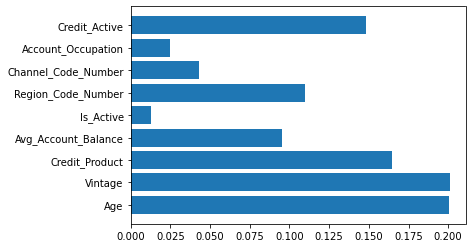

In [364]:
plt.barh(X.columns, random_forest.feature_importances_);

In [365]:
y_preds = random_forest.predict(X_val)
roc_auc_score(y_val, y_preds)

0.8866621760624378

### VotingClassifier

In [366]:
from sklearn.ensemble import VotingClassifier
voting_model = VotingClassifier(estimators=[('rf', random_forest),
                                            ('ada', ada_model),
                                           ('xg', xg_model)], verbose=True)
voting_model.fit(X_train, y_train)
voting_model.score(X_val, y_val)

[Voting] ....................... (1 of 3) Processing rf, total= 3.1min
[Voting] ...................... (2 of 3) Processing ada, total=  12.0s
[19:17:54] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Voting] ....................... (3 of 3) Processing xg, total=  42.2s


0.891510503501167

In [367]:
y_preds = voting_model.predict(X_val)
roc_auc_score(y_val, y_preds)

0.8914751043989272

### AdaBoostClassifier

In [368]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
ada_model.score(X_val, y_val)

0.8104968322774259

In [369]:
y_preds = ada_model.predict(X_val)
roc_auc_score(y_val, y_preds)

0.8104541681020108

### XGBoostClassifier

In [389]:
from xgboost import XGBClassifier
xg_model = XGBClassifier(learning_rate=0.5, alpha=6, booster='dart')
xg_model.fit(X_train, y_train)
xg_model.score(X_val, y_val)

[19:25:02] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9038212737579193

In [390]:
y_preds = xg_model.predict(X_val)
roc_auc_score(y_val, y_preds)

0.9037436139316706

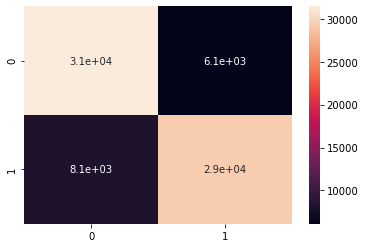

In [387]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, y_preds), annot=True);

In [388]:
confusion_matrix(y_val, y_preds)

array([[31448,  6111],
       [ 8122, 29294]], dtype=int64)

In [425]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(learning_rate='adaptive', max_iter=300)
mlp_model.fit(X_train, y_train)
mlp_model.score(X_val, y_val)

0.8047482494164722

In [426]:
y_preds = mlp_model.predict(X_val)

In [427]:
confusion_matrix(y_val, y_preds)

array([[32117,  5442],
       [ 9197, 28219]], dtype=int64)

## Submission

In [422]:
y_preds = mlp_model.predict(test.drop(['Region_Code_Id', 'Channel_Code_Id', 'Occupation', 'Gender'], axis=1))

In [423]:
submission = pd.DataFrame(y_preds, columns=['Is_Lead'])
submission.index = test_ds.ID
submission.index.name = "ID"

In [424]:
submission.to_csv("../submission/mlp_model_over_new2.csv")